## Install Packages

In [ ]:
!pip install dagshub
!pip install mlflow
!pip install pydantic==1.10.9
!pip install ipyplot

## Setup the Google Colab

In [1]:
import os
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import ipyplot

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#%env DATA_DIRECTORY = C:\Workspace\Practice\Python\LeraningWorkspace\data

In [4]:
%env DATA_DIRECTORY = /home/ubuntu/Downloads
%env TEST_DATA_DIRECTORY = /home/ubuntu/Downloads

env: DATA_DIRECTORY=/home/ubuntu/Downloads
env: TEST_DATA_DIRECTORY=/home/ubuntu/Downloads


In [5]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/ubuntu/Downloads


## Add some utility functions here

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report

def evaluate_classification_multi(y_true, y_pred):
    """Evaluates a classification model by calculating and printing various metrics.

    Args:
        y_true (array): True class values.
        y_pred (_type_): Predicted class values.

    Returns:
        dictionary: Dictionary containing various evaluation metrics including Accuracy, F1 Score, Recall, Confusion Matrix.
    """
    classes = ['Cescospora','Healthy','Miner','Phoma','Rust']

    # 1 - Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # 2 - Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # 3 - F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')

    # 4 - Recall for each class
    recall_each_class = recall_score(y_true, y_pred, average=None)
    recall_dict = {classes[i]: recall for i, recall in enumerate(recall_each_class)}

    # 5 - Print Classification Report
    print(classification_report(y_true, y_pred))

    metrics = {
        'Accuracy': round(accuracy,2),
        'F1 Score macro': round(f1,2),
        'Cescospora Recall': round(recall_dict['Cescospora'],2),
        'Healthy Recall': round(recall_dict['Healthy'],2),
        'Miner Recall': round(recall_dict['Miner'],2),
        'Phoma Recall': round(recall_dict['Phoma'],2),
        'Rust Recall': round(recall_dict['Rust'],2),
        'Confusion Matrix': conf_matrix
    }

    return metrics

In [7]:
def mlflow_track(experiment_name, metrics,model,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch):
    """Tracks machine learning experiments using MLflow, including tagging and logging various parameters and metrics.

    Args:
        experiment_name (str): Name of the experiment for grouping and filtering purposes.
        metrics (dict): Dictionary containing evaluation metrics, such as ROC AUC, F1 Score, Recall, TP Rate, FP Rate, etc.
        model (str): Model used in the experiment.
        X (DataFrame): DataFrame containing the features used in the model.
        strategy (str): Strategy employed in the experiment.
        preprocess (str): Preprocessing technique used.
        split (str): Description of the data splitting strategy.
        threshold_defined (float): Manually defined threshold used in predictions.
        obs (str): Any additional observations or notes related to the experiment.

    Note:
        The function uses MLflow to set up an experiment with the given name, tags the experiment with the specified parameters,
        and logs metrics for the experiment. It also ends the current MLflow run after logging, so each call to this function
        should correspond to a distinct experiment run.

    """

    #label para filtrar os experimentos
    mlflow.set_experiment(experiment_name=experiment_name)

    #tags para organizar os experimentos
    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    tags = {
            "model": model,
            "strategy":strategy,
            "features": X,
            "preprocess":preprocess,
            "split":split,
            'obs':obs
        }


    #salvando métricas no experimento setado acima
    mlflow.set_tags(tags)

    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    # mlflow.log_param("random_state", random_state)
    mlflow.log_param("loss", loss)
    mlflow.log_param("metrics_optmizer", metrics_optmizer)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_batch", train_batch)
    mlflow.log_param("val_batch", val_batch)


    mlflow.log_metric("Accuracy", metrics['Accuracy'])
    mlflow.log_metric("F1 Score macro", metrics['F1 Score macro'])
    mlflow.log_metric("Cescospora Recall", metrics['Cescospora Recall'])
    mlflow.log_metric("Healthy Recall", metrics['Healthy Recall'])
    mlflow.log_metric("Miner Recall", metrics['Miner Recall'])
    mlflow.log_metric("Phoma Recall", metrics['Phoma Recall'])
    mlflow.log_metric("Rust Recall", metrics['Rust Recall'])

    #para fechar a conexão anterior, sempre fechar a conexão depois de iniciar cada experimento
    mlflow.end_run()

In [8]:
## Code to clean kaggle output folders
def remove_folder_contents(folder, recurse=False):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                if recurse is True:
                    remove_folder_contents(file_path)
                    os.rmdir(file_path)
                continue
        except Exception as e:
            print(e)

In [9]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [10]:
def buildCropDiseaseCountTuple(instanceFolder):
    # Name of Crop and Disease is the folder name so split it . Need to change the logic here based on the data source . Much Pain!!
    # Count will be just samples within the folder
    str_name = str(instanceFolder.name)
    str_name = str_name.replace(" leaf", "").rstrip()
    print(str_name)
    values = str_name.split(" ", 2)
    f = instanceFolder.rglob('*')
    counts = np.unique([x.parent for x in f], return_counts=True)[1]
    if len(values) == 1:
        values = ['Coffee', values[0]]
        #values.append('healthy')
    return (values[0], values[1], counts[0].tolist())

In [11]:
def readFolderAndSaveDataFrame(DataFolder, classNames=None):
    '''
    Read the folder - Note the assumption here is that the images are already seperated into their respective class subfolders
    Example -
        <root>
            - <class 1>
                - <image 1>
                - <image 2>
            - <class 2>
                - <image 1>
                - <image 2>
    '''
    dataFolder = Path(f"{DataFolder}")
    dataList = []
    # Get all the folders within the path - The list of folders are the classes.
    if classNames != None:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir() and f.name in classNames]
    else:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir()]
    for classPath in instancePathList:
        dataList.append(buildCropDiseaseCountTuple(classPath))

    ## Make a DataFrame
    samplesDataFrame = pd.DataFrame(dataList, columns=['Crop', 'Disease', 'numberImages'])
    return samplesDataFrame

In [12]:
def generate_pie_plot(df, title="Categories", ax = None):
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [13]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames, outputfilename):
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath(outputfilename))

In [14]:
## Load all the images and the keypoints
def LoadData(inputDir, imageSize):
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            #img = cv2.imread(str(inputDir.joinpath(file)))
            #plt.imshow(img)
            #plt.show()
            all_classes.append(df.iloc[i]['ClassName'])
            #img = cv2.resize(img, (imageSize, imageSize))
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

In [15]:
def resize_image(input_folder, output_folder):
  for c in CLASSNAMES:
    folder_path = Path(input_folder)/c
    output_path = Path(output_folder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      #print(image_path)
      img = cv2.imread(str(image_path))
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, [256, 256])
      cv2.imwrite(str(output_path/image_path.name), img)
      #print(output_path/image_path.name)
  return

In [16]:
def VisualizeAsClassTabs(csvFile, classNames, size):
  df = pd.read_csv(csvFile)
  inputDir = csvFile.parent
  image_array = []
  label_array = []
  for c in CLASSNAMES:
    cdf = df.query(f'ClassName == "{c}"')
    for i in np.random.choice(np.arange(0, cdf.shape[0]), size=(size,)):
      file = cdf.iloc[i]['FileName']
      img = cv2.imread(str(inputDir.joinpath(file)))
      label_array.append(cdf.iloc[i]['ClassName'])
      image_array.append(img)

  ipyplot.plot_class_tabs(image_array, label_array, max_imgs_per_tab = size, img_width=150)

## Get the coffee dataset

In [17]:
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

/home/ubuntu/Downloads


In [18]:
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust'] 

In [19]:
SINGLE_LEAVES_DATA_DIR_TRAIN = Path(root_dir).joinpath('train_opencv_resized_rot')

In [20]:
testDirectory = os.environ.get("TEST_DATA_DIRECTORY")
SINGLE_LEAVES_DATA_DIR_TEST = Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized')

In [21]:
checkPathExists(SINGLE_LEAVES_DATA_DIR_TEST)
checkPathExists(SINGLE_LEAVES_DATA_DIR_TRAIN)

Path /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized accessible
Path /home/ubuntu/Downloads/train_opencv_resized_rot accessible


### Only run the first time. Make the CSVs to load the image data conveniently

In [22]:
coffeedatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES)
coffeetestdatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES)

Phoma
Rust
Cescospora
Miner
Healthy
Phoma
Rust
Cescospora
Miner
Healthy


In [23]:
coffeedatadf.head()
coffeetestdatadf.head()

,Crop,Disease,numberImages
0,Coffee,Phoma,107
1,Coffee,Rust,921
2,Coffee,Cescospora,112
3,Coffee,Miner,369
4,Coffee,Healthy,791


Proportion of data in class Phoma is 3304 : 19.32 %
Proportion of data in class Rust is 6684 : 39.08 %
Proportion of data in class Cescospora is 800 : 4.68 %
Proportion of data in class Miner is 4036 : 23.60 %
Proportion of data in class Healthy is 2280 : 13.33 %
Proportion of data in class Phoma is 107 : 4.65 %
Proportion of data in class Rust is 921 : 40.04 %
Proportion of data in class Cescospora is 112 : 4.87 %
Proportion of data in class Miner is 369 : 16.04 %
Proportion of data in class Healthy is 791 : 34.39 %


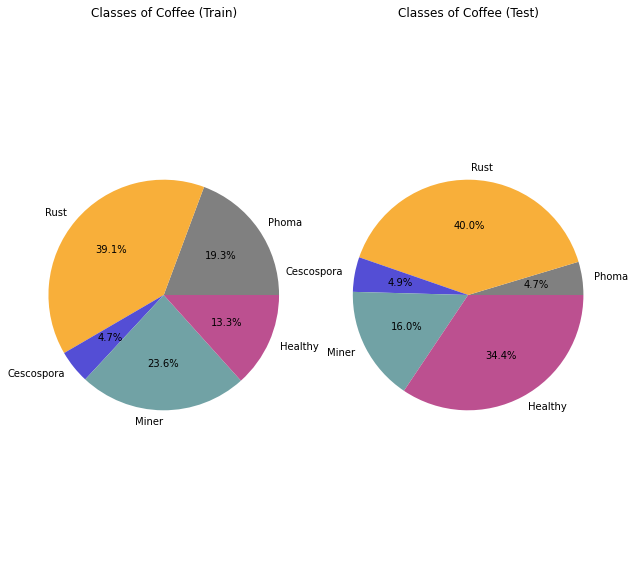

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
generate_pie_plot(coffeedatadf, 'Classes of Coffee (Train)', ax[0])
generate_pie_plot(coffeetestdatadf, 'Classes of Coffee (Test)', ax[1])

Building a CSV metafile of image info that I will use to load the data later

In [25]:
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TRAIN, SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES, 'coffeediseasedata.csv')
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TEST, SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES, 'coffeediseasetestdata.csv')

Tracking /home/ubuntu/Downloads/train_opencv_resized_rot/Phoma
Tracking /home/ubuntu/Downloads/train_opencv_resized_rot/Rust
Tracking /home/ubuntu/Downloads/train_opencv_resized_rot/Cescospora
Tracking /home/ubuntu/Downloads/train_opencv_resized_rot/Miner
Tracking /home/ubuntu/Downloads/train_opencv_resized_rot/Healthy
17104
(17104, 5)
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Phoma
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Rust
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Cescospora
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Miner
Tracking /home/ubuntu/Downloads/000_test_and_val_dataset_opencv_resized/Healthy
2300
(2300, 5)


## Load the Corn Data for Training

In [26]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR_TRAIN / 'coffeediseasedata.csv'
batch_size = 32

In [27]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TRAIN, IMAGE_SIZE)

17104


Split test data into validation and testing images

In [28]:
coffee_test_images, coffee_test_classes, coffee_test_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TEST, IMAGE_SIZE)

2300


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
alt_images, alt_test_images, alt_id, alt_test_id, alt_class, alt_test_class = \
train_test_split(coffee_test_images, coffee_test_ids, coffee_test_classes,
                 test_size=0.9, random_state=1234, shuffle=True, stratify=coffee_test_classes)

val_images, test_images, val_id, test_id, val_class, test_class = \
train_test_split(alt_test_images, alt_test_id, alt_test_class,
                 test_size=0.5, random_state=1234, shuffle=True, stratify=alt_test_class)

In [31]:
train_df = pd.DataFrame(np.array(np.unique(coffee_classes, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
val_df = pd.DataFrame(np.array(np.unique(val_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
test_df['numberImages'] = test_df['numberImages'].astype('int32')
val_df['numberImages'] = val_df['numberImages'].astype('int32')

Proportion of data in class Cescospora is 800 : 4.68 %
Proportion of data in class Healthy is 2280 : 13.33 %
Proportion of data in class Miner is 4036 : 23.60 %
Proportion of data in class Phoma is 3304 : 19.32 %
Proportion of data in class Rust is 6684 : 39.08 %
Proportion of data in class Cescospora is 50 : 4.83 %
Proportion of data in class Healthy is 356 : 34.40 %
Proportion of data in class Miner is 166 : 16.04 %
Proportion of data in class Phoma is 48 : 4.64 %
Proportion of data in class Rust is 415 : 40.10 %
Proportion of data in class Cescospora is 51 : 4.93 %
Proportion of data in class Healthy is 356 : 34.40 %
Proportion of data in class Miner is 166 : 16.04 %
Proportion of data in class Phoma is 48 : 4.64 %
Proportion of data in class Rust is 414 : 40.00 %


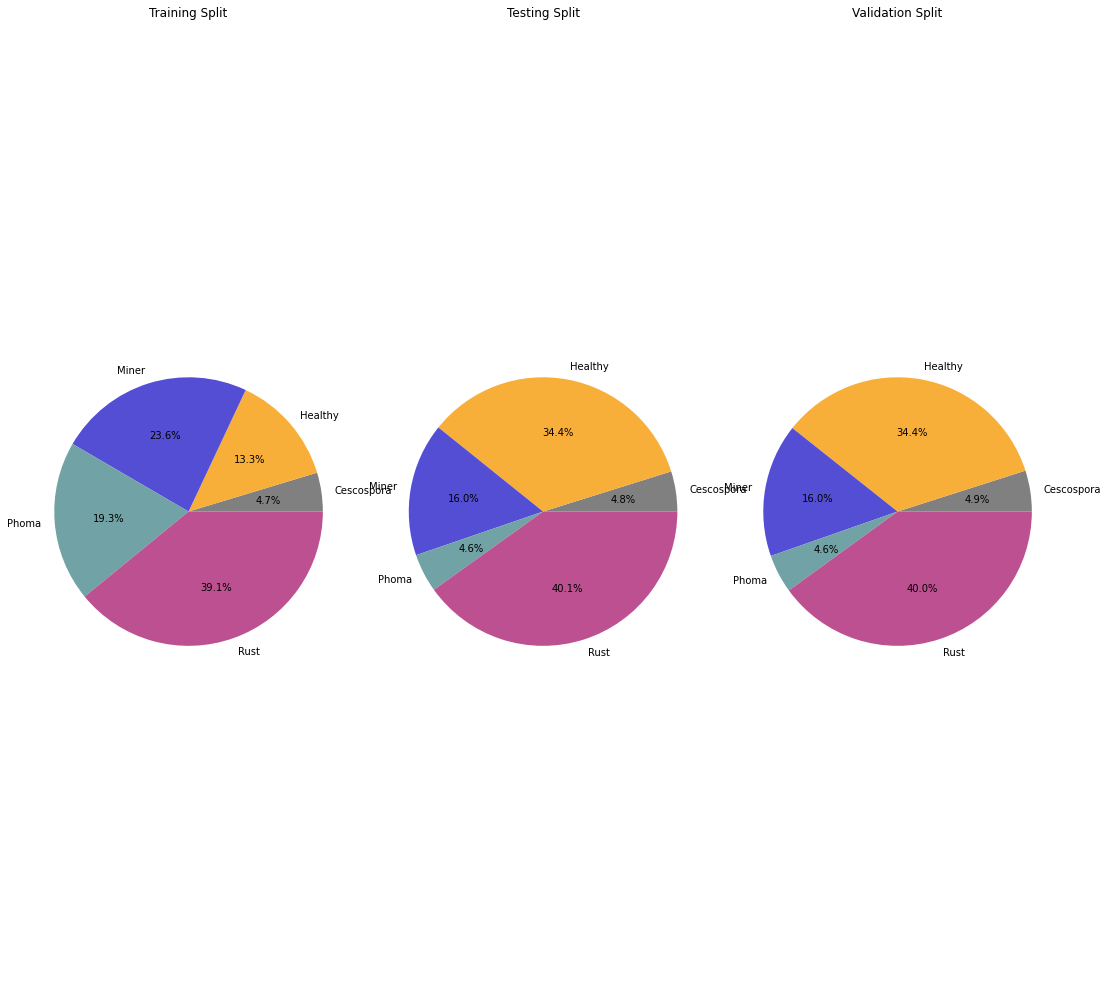

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18,18))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(test_df, title="Testing Split", ax=ax[1])
generate_pie_plot(val_df, title="Validation Split", ax=ax[2])

In [33]:
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


In [34]:
import tensorflow as tf

Visualize some sample input images

In [35]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

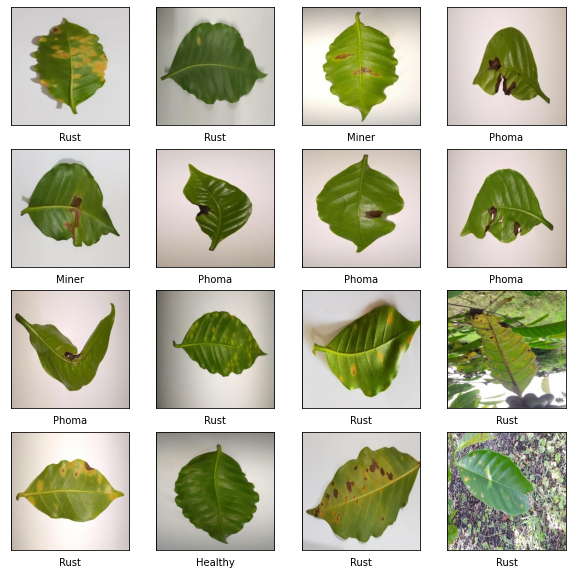

In [36]:
plt.subplots(4, 4, figsize=(10,10))
num_total = coffee_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    image = cv2.imread(coffee_images[k])
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, True)
    plt.xlabel(coffee_classes[k])

Make a Tensorflow dataset

In [37]:
train_ds = tf.data.Dataset.list_files(coffee_images.tolist(), shuffle=False)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

In [38]:
val_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)
alt_ds = tf.data.Dataset.list_files(alt_images.tolist(), shuffle=False)
train_ds = train_ds.concatenate(alt_ds)

In [39]:
for f in train_ds.take(5):
  print(f.numpy())

b'/home/ubuntu/Downloads/train_opencv_resized_rot/Healthy/Aug_rot_0_cld-kaggle-train-healthy (228).jpg'
b'/home/ubuntu/Downloads/train_opencv_resized_rot/Healthy/Aug_rot_180_cld-kaggle-train-healthy (48).jpg'
b'/home/ubuntu/Downloads/train_opencv_resized_rot/Rust/Aug_rot_0_cld-kaggle-train-rust (108).jpg'
b'/home/ubuntu/Downloads/train_opencv_resized_rot/Cescospora/Aug_rot_180_IMG_20221126_111523-434x768_jpg.rf.5adce44e19f9e2a707815407d6729b55.jpg'
b'/home/ubuntu/Downloads/train_opencv_resized_rot/Rust/Aug_rot_270_168.jpg'


In [40]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

17334
1035


In [41]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [42]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
for image, label in train_ds.take(5):
  #print("File name: ", filename.numpy())
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  0
Image shape:  (256, 256, 3)
Label:  0
Image shape:  (256, 256, 3)
Label:  4
Image shape:  (256, 256, 3)
Label:  1
Image shape:  (256, 256, 3)
Label:  4


In [44]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

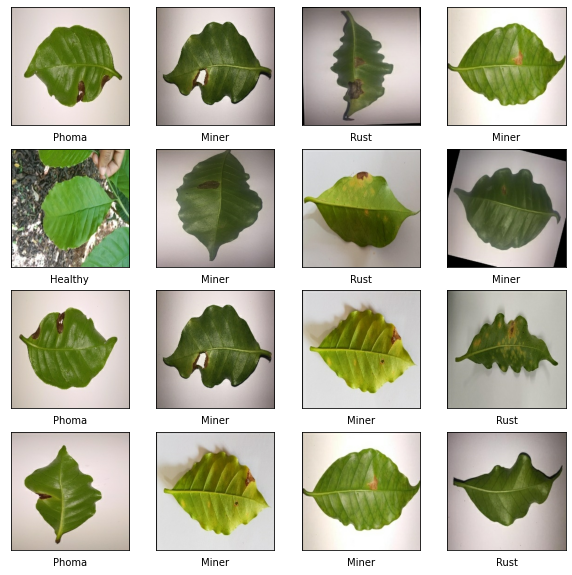

In [45]:
image_batch, label_batch = next(iter(train_ds))

plt.subplots(4, 4, figsize=(10,10))
for i, k in enumerate(np.random.randint(batch_size, size=16)):
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[k].numpy().astype("uint8"))
    plt.xlabel(CLASSNAMES[label_batch[k]])

### Build the Coffee Disease Classification model

MobileNetv2

In [46]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization

In [47]:
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [48]:
MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(512, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
outputs = Dense(len(CLASSNAMES), activation='softmax')(x)
#Model
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()

Model: "Coffee_Disease_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 DropOut (Dropout)           (None, 8, 8, 1280)        0         
                                         

In [112]:
MODEL_NAME = 'Coffee_Disease_Classifier_V2'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
# Separable Convolutional Operation
x = SeparableConv2D(128, kernel_size=3, activation='relu', data_format='channels_last', name="ConvPass")(x)
x = Flatten()(x)
# Outputs
outputs = Dense(len(CLASSNAMES), activation='softmax', name="OutputLayer")(x)
#Model
model_2 = Model(inputs, outputs, name=MODEL_NAME)
model_2.summary()

Model: "Coffee_Disease_Classifier_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 DropOut (Dropout)           (None, 8, 8, 1280)        0         
                                      

In [113]:
for image, label in val_ds.take(1):
  print(image.numpy().shape)

(32, 256, 256, 3)


In [114]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [115]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [116]:
WEIGHT_DIR = Path('/home/ubuntu/Downloads/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

1.5003508771929825
Epoch 1/25
1/1 [==============================] - 1s 679ms/step loss: 1.2011 - accuracy: 0.66


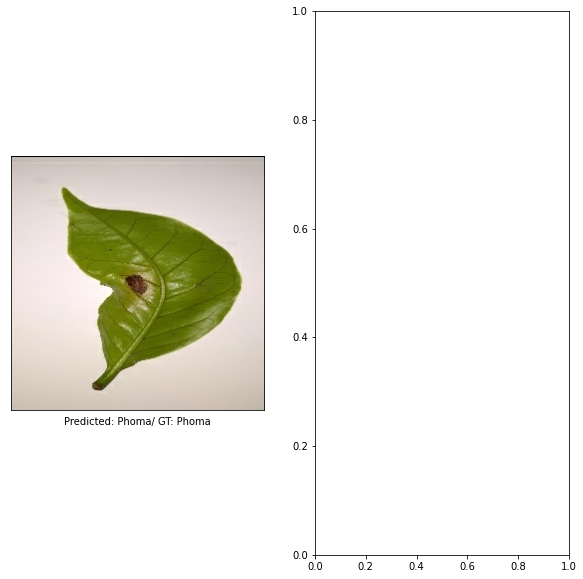

542/542 [==============================] - 19s 30ms/step - loss: 1.2011 - accuracy: 0.6694 - val_loss: 1.4155 - val_accuracy: 0.5121
Epoch 2/25
542/542 [==============================] - 14s 26ms/step - loss: 0.4346 - accuracy: 0.8563 - val_loss: 1.5758 - val_accuracy: 0.5101
Epoch 3/25
542/542 [==============================] - 14s 26ms/step - loss: 0.2681 - accuracy: 0.8752 - val_loss: 1.7841 - val_accuracy: 0.5072
Epoch 4/25
542/542 [==============================] - 14s 27ms/step - loss: 0.2376 - accuracy: 0.8790 - val_loss: 1.8851 - val_accuracy: 0.5169
Epoch 5/25
163/542 [========>.....................] - ETA: 9s - loss: 0.2040 - accuracy: 0.8836

KeyboardInterrupt: 

In [117]:
EPOCHS=25
NUMCLASS = len(CLASSNAMES)
# Compile
backbone.trainable = False
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-5),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
totalImages = coffeedatadf.numberImages.sum()
healthyCount = coffeedatadf.query('Disease == "Healthy"')['numberImages']
CesCount = coffeedatadf.query('Disease == "Cescospora"')['numberImages']
MinerCount = coffeedatadf.query('Disease == "Miner"')['numberImages']
PhomaCount = coffeedatadf.query('Disease == "Phoma"')['numberImages']
RustCount = coffeedatadf.query('Disease == "Rust"')['numberImages']
print(totalImages/(NUMCLASS*healthyCount.iloc[0]))
weights = {0:(totalImages/(NUMCLASS*healthyCount.iloc[0])), 1:(totalImages/(NUMCLASS*CesCount.iloc[0])), 2:(totalImages/(NUMCLASS*MinerCount.iloc[0])), 3:(totalImages/(NUMCLASS*PhomaCount.iloc[0])), 4:(totalImages/(NUMCLASS*RustCount.iloc[0]))} #
#weights = {0:(totalImages/(3*healthyCount)), 1:(totalImages/(3*PhomaCount)), 2:(totalImages/(3*RustCount))} #1:(totalImages/(5*CesCount)),
history = model_2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      #steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

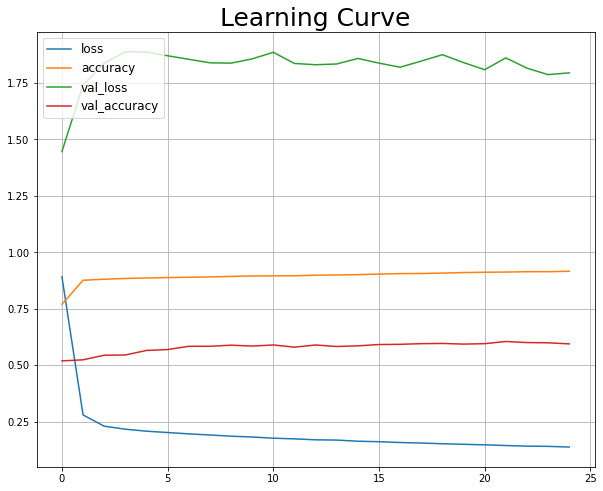

In [84]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Fine Tune

In [85]:
backbone.trainable = True
#model_1.compile(loss='sparse_categorical_crossentropy',
#                optimizer=Adam(learning_rate=1e-5),
#                metrics=['accuracy']) # Lower the Learning Rate better the results.
import tensorflow.keras.backend as K
K.set_value(model_2.optimizer.learning_rate, 1e-6)

Epoch 1/25
1/1 [==============================] - 0s 26ms/step- loss: 0.1413 - accuracy: 0.91


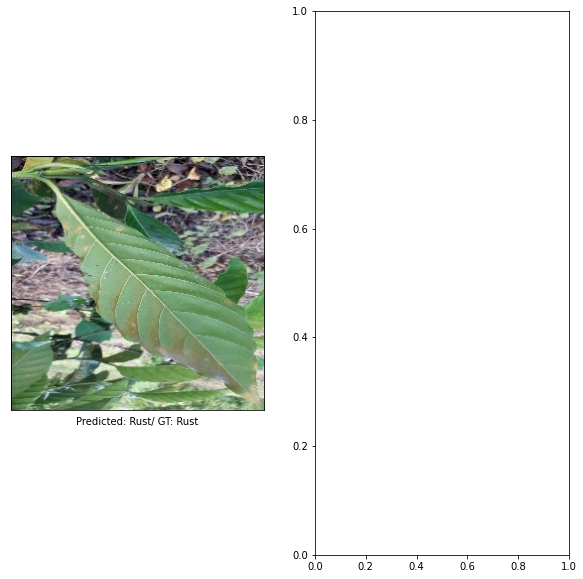

542/542 [==============================] - 15s 27ms/step - loss: 0.1413 - accuracy: 0.9146 - val_loss: 2.0359 - val_accuracy: 0.5507
Epoch 2/25
542/542 [==============================] - 14s 27ms/step - loss: 0.1345 - accuracy: 0.9168 - val_loss: 2.0952 - val_accuracy: 0.5411
Epoch 3/25
542/542 [==============================] - 15s 28ms/step - loss: 0.1346 - accuracy: 0.9166 - val_loss: 2.1070 - val_accuracy: 0.5401
Epoch 4/25
542/542 [==============================] - 14s 27ms/step - loss: 0.1337 - accuracy: 0.9180 - val_loss: 2.1073 - val_accuracy: 0.5391
Epoch 5/25
542/542 [==============================] - 15s 27ms/step - loss: 0.1334 - accuracy: 0.9172 - val_loss: 2.1251 - val_accuracy: 0.5391
Epoch 6/25
542/542 [==============================] - 15s 27ms/step - loss: 0.1335 - accuracy: 0.9170 - val_loss: 2.1228 - val_accuracy: 0.5391
Epoch 7/25
542/542 [==============================] - 14s 26ms/step - loss: 0.1330 - accuracy: 0.9176 - val_loss: 2.1251 - val_accuracy: 0.5401
Epo

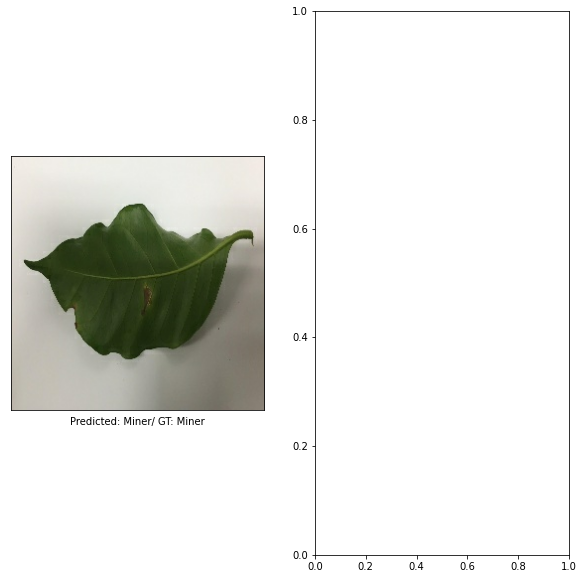

542/542 [==============================] - 14s 26ms/step - loss: 0.1303 - accuracy: 0.9199 - val_loss: 2.1317 - val_accuracy: 0.5411
Epoch 22/25
542/542 [==============================] - 15s 27ms/step - loss: 0.1301 - accuracy: 0.9192 - val_loss: 2.1295 - val_accuracy: 0.5411
Epoch 23/25
542/542 [==============================] - 14s 26ms/step - loss: 0.1296 - accuracy: 0.9197 - val_loss: 2.1346 - val_accuracy: 0.5411
Epoch 24/25
542/542 [==============================] - 14s 26ms/step - loss: 0.1292 - accuracy: 0.9212 - val_loss: 2.1398 - val_accuracy: 0.5401
Epoch 25/25
542/542 [==============================] - 15s 27ms/step - loss: 0.1293 - accuracy: 0.9187 - val_loss: 2.1368 - val_accuracy: 0.5411


In [86]:
history = model_2.fit(train_ds,
                      validation_data=val_ds,
                      #initial_epoch=50,
                      epochs=EPOCHS,
                      #steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

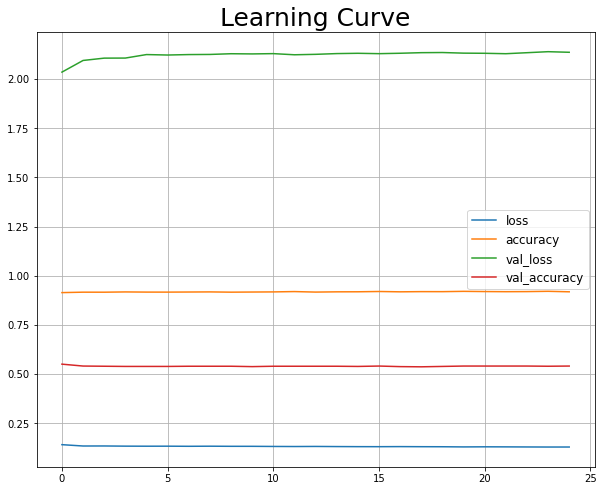

In [87]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Error Analysis

In [88]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [89]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [90]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [ ]:
train_true, train_pred = generateMatrix(train_ds)

1/1 [==============================] - 0s 30ms/step


In [106]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.86      0.96      0.91      2359
  Cescospora       0.92      0.48      0.63       811
       Miner       0.87      0.72      0.79      4073
       Phoma       0.97      0.97      0.97      3315
        Rust       0.81      0.90      0.85      6776

    accuracy                           0.86     17334
   macro avg       0.88      0.81      0.83     17334
weighted avg       0.86      0.86      0.86     17334



In [107]:
val_true, val_pred = generateMatrix(val_ds)

1/1 [==============================] - 0s 22ms/step
Accuracy of model: 0.42318840579710143
Predicted   0  1    2   3    4
Actual                        
0          57  1    0   0  298
1           8  0    2  10   31
2           1  0  105  13   47
3           0  0   16  14   18
4          10  0   59  83  262
Sensitivity of model for individual classes
Class Healthy : 0.1601123595505618
Class Cescospora : 0.0
Class Miner : 0.6325301204819277
Class Phoma : 0.2916666666666667
Class Rust : 0.6328502415458938


In [108]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.75      0.16      0.26       356
  Cescospora       0.00      0.00      0.00        51
       Miner       0.58      0.63      0.60       166
       Phoma       0.12      0.29      0.17        48
        Rust       0.40      0.63      0.49       414

    accuracy                           0.42      1035
   macro avg       0.37      0.34      0.30      1035
weighted avg       0.52      0.42      0.39      1035



1/1 [==============================] - 0s 24ms/step


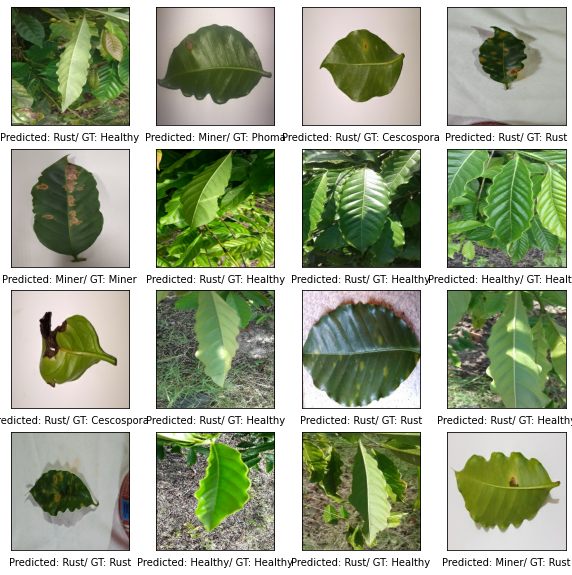

In [109]:
plt.subplots(4, 4, figsize=(10, 10))
for image, label in val_ds.take(1):
    pred_kps = model_1.predict(image)
    for i, k in enumerate(np.random.randint(batch_size, size=16)):
      plt.subplot(4, 4, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image[i].numpy().astype("uint8"))
      plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[i]]}/ GT: {CLASSNAMES[label[i]]}")
    #plt.xlabel(f"GT:{input_class[k]}")
plt.show()

In [110]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
metrics = evaluate_classification_multi(val_true, val_pred)

              precision    recall  f1-score   support

           0       0.75      0.16      0.26       356
           1       0.00      0.00      0.00        51
           2       0.58      0.63      0.60       166
           3       0.12      0.29      0.17        48
           4       0.40      0.63      0.49       414

    accuracy                           0.42      1035
   macro avg       0.37      0.34      0.30      1035
weighted avg       0.52      0.42      0.39      1035



In [111]:
metrics

{'Accuracy': 0.42,
 'F1 Score macro': 0.3,
 'Cescospora Recall': 0.16,
 'Healthy Recall': 0.0,
 'Miner Recall': 0.63,
 'Phoma Recall': 0.29,
 'Rust Recall': 0.63,
 'Confusion Matrix': array([[ 57,   1,   0,   0, 298],
        [  8,   0,   2,  10,  31],
        [  1,   0, 105,  13,  47],
        [  0,   0,  16,  14,  18],
        [ 10,   0,  59,  83, 262]])}

## MLFLOW Saving experiment

In [ ]:
strategy = 'fine tuned MobileNetV2 using strategy 002 dataset'
preprocess = 'resize 256x256, interpolation nearest, softmax last layer, optmize adam'
split = 'already split'
obs = 'using the test and val dataset provided from task 4, with no augmentation or preprocessing'
X = 'all images on strategy 2 dataset'
modelname = 'Coffee_Disease_Classifier'

loss = 'sparse_categorical_crossentropy'
metrics_optmizer = 'accuracy'
learning_rate=1e-6
train_batch = 32
val_batch = 32

In [ ]:
import dagshub

In [ ]:
#don't need to change
dagshub.init("mlflow_free_omdena",'dpai', mlflow=True)

In [ ]:
import mlflow

In [ ]:
mlflow.set_tracking_uri('https://dagshub.com/lucasvascrocha/mlflow_free_omdena.mlflow')

In [ ]:
experiment_name = 'approach1'
mlflow_track(experiment_name, metrics,model_1,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch)


## Evaluate from saved model

In [ ]:
checkPathExists(Path(testDirectory).parent/'models/MobileNetV2_weights')

In [ ]:
from tensorflow.train import latest_checkpoint
latest = latest_checkpoint(Path(testDirectory).parent/'models/MobileNetV2_weights')
latest